# 0. Imports y funciones útiles

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None) # para mostrar todas las filas
pd.set_option('display.max_columns', None) # para mostrar todas las columnas

# 1. Análisis exploratorio

Por agilizar el ejemplo se usa airbnb-listings-extract en vez del full. Lo primero que vamos a hacer es dividir el dataset en training y test, metiéndole ``shuffle`` y ``random_state`` como siempre. Guardamos los resultados en dos ficheros csv para que sea más manejable.

In [2]:
from sklearn.model_selection import train_test_split

full_df = pd.read_csv('./airbnb-listings-extract.csv', sep=';', decimal='.')
train, test = train_test_split(full_df, test_size=0.2, shuffle=True, random_state=0)

print(f'Dimensiones del dataset de training: {train.shape}')
print(f'Dimensiones del dataset de test: {test.shape}')

# Guardamos
train.to_csv('./train.csv', sep=';', decimal='.', index=False)
test.to_csv('./test.csv', sep=';', decimal='.', index=False)

Dimensiones del dataset de training: (11824, 89)
Dimensiones del dataset de test: (2956, 89)


A partir de este momento cargamos el dataset de train y trabajamos ÚNICAMENTE con él. 

In [3]:
df = pd.read_csv('./train.csv', sep=';', decimal='.')

Se usa head traspuesto para ver de qué va cada columna:

In [4]:
df.head().T

,0,1,2,3,4
ID,5994463,14136180,15520134,8809721,1162707
Listing Url,https://www.airbnb.com/rooms/5994463,https://www.airbnb.com/rooms/14136180,https://www.airbnb.com/rooms/15520134,https://www.airbnb.com/rooms/8809721,https://www.airbnb.com/rooms/1162707
Scrape ID,20170407214119,20170407214119,20170407214119,20170407214119,20170407214119
Last Scraped,2017-04-08,2017-04-08,2017-04-08,2017-04-08,2017-04-08
Name,PISO ATOCHA- FLAT NEAR ATOCHA .,The Palace Sol Madrid.,por persona la noche metro linea5 vista alegre,CITY CENTER JACINTO BENAVENTE ROOM4,NICE & BIG DOUBLE ROOM AT DOWNTOWN
Summary,Piso recién reformado cómoda habitación con ba...,"Lugares de interés: Plaza Mayor, Plaza del Sol...","我的房源靠近餐厅和餐饮、适合家庭的活动、公共交通。因为舒适的床、温馨、厨房、景观,您一定会爱...",This stunning and amazig room is covered with ...,NaN
Space,"Un piso muy cómodo en Jerónimos, una de las zo...",El apartamento dispone de un dormitorio indepe...,NaN,NaN,We are a young couple; David (Spain) and Ana (...
Description,Piso recién reformado cómoda habitación con ba...,"Lugares de interés: Plaza Mayor, Plaza del Sol...","我的房源靠近餐厅和餐饮、适合家庭的活动、公共交通。因为舒适的床、温馨、厨房、景观,您一定会爱...",This stunning and amazig room is covered with ...,We are a young couple; David (Spain) and Ana (...
Experiences Offered,none,none,none,none,none
Neighborhood Overview,El barrio de Jeronimos es un enclave tranquilo...,"Situado en el corazón de Madrid, este apartame...",NaN,NaN,NaN


Se ve que gran parte de los datos no aportan información relevante. Se van a eliminar de inmediato las columnas:

- Listing Url
- Scrape ID: no aporta información sobre la propiedad.
- Last Scraped: no aporta información sobre la propiedad.
- Thumbnail Url
- Medium Url
- Picture Url
- XL Picture Url
- Host ID: aporta información sobre el dueño, pero no sobre la propiedad (podría revisarse su inclusión si los resultados no son buenos).
- Host Url
- Host Name: no aporta información sobre la propiedad. Podría ser de interés estadístico otro tipo de dato categórico del dueño (rango de edad, sexo...) pero no el nombre.
- Host Thumbnail Url
- Host Picture Url
- Host Neighbourhood: no aporta información sobre la propiedad.
- Weekly Price: información redundante que puede actuar como predictor (y no debe)
- Monthly Price: información redundante que puede actuar como predictor (y no debe)
- Calendar Updated: información irrelevante; se podría inferir la frecuencia de actividad del dueño, pero YA hay un dato explícito de su tasa de respuesta.
- Calendar last Scraped: no aporta información sobre la propiedad.
- First review: no aporta información nueva; ya hay un dato de antiguedad del dueño.
- Last review: no aporta información nueva.
- Reviews per Month: no aporta información nueva
- Geolocation: es latitud + longitud
- Host Listings Count, Host Total Listings Count, Calculated host listings count: contador relacionado con el dueño; no aporta información sobre la propiedad.


In [5]:
# Hacemos un drop de todas las columnas que OBVIAMENTE no aportan información relevante
not_useful_columns = [
    'ID', 'Listing Url', 'Scrape ID', 'Last Scraped', 'Thumbnail Url', 'Medium Url', 
    'Picture Url', 'XL Picture Url', 'Host ID', 'Host URL', 'Host Name', 
    'Host Thumbnail Url', 'Host Picture Url', 'Host Neighbourhood', 'Weekly Price', 
    'Monthly Price', 'Calendar Updated', 'Calendar last Scraped', 'First Review', 
    'Last Review', 'Reviews per Month', 'Geolocation', 'Calculated host listings count',
    'Host Listings Count', 'Host Total Listings Count'
]

df.drop(not_useful_columns, axis=1, inplace=True)

Y luego hay una serie de columnas que, si bien aportan mucha información, exigen un tratamiento previo que queda fuera del alcance de este trabajo. Name, summary, description... exigirían tokenización y un análisis con NLP para poder sacar algo en claro, de modo que se eliminan. En un entorno real, probablemente tendréis que realizar ese análisis :) y si alguien lo ha hecho, lo tendré muy en cuenta!

In [6]:
# Hacemos un drop de todas las columnas que aportando información quedan fuera del scope
somehow_useful_columns_but_droppable_anyway = ['Name', 'Summary', 'Space', 'Description',
       'Neighborhood Overview', 'Notes', 'Transit', 'Access', 'Interaction', 'House Rules',
       'Host Location', 'Host About'
]

df.drop(somehow_useful_columns_but_droppable_anyway, axis=1, inplace=True)

Se analiza el número de valores diferentes por columnas.

In [7]:
df.apply(lambda x: len(x.unique()))

Experiences Offered                 5
Host Since                       2044
Host Response Time                  5
Host Response Rate                 68
Host Acceptance Rate               11
Host Verifications                192
Street                           1438
Neighbourhood                     352
Neighbourhood Cleansed            444
Neighbourhood Group Cleansed       48
City                              223
State                              94
Zipcode                           536
Market                             43
Smart Location                    232
Country Code                       18
Country                            18
Latitude                        11824
Longitude                       11824
Property Type                      21
Room Type                           3
Accommodates                       16
Bathrooms                          18
Bedrooms                           11
Beds                               17
Bed Type                            5
Amenities   

La variable Street no muestra realmente la calle; en muchas, simplemente es la ciudad y un código postal (variables que ya tienen su propia columna). Es una variable muy ruidosa y no categorizada.

Por otro lado, City, State, Market y Smart Location aportan la misma información, al igual que Country y Country Code y de forma similar a Neighbourhood y Zipcode. Este paso es controvertido; es aventurado eliminar sin más estas columnas. Sin embargo, es válido para una primera aproximación. Nos quedamos con City y eliminamos las demás.

**Nota**: en este caso concreto, con esta selección de listings, la inmensísima mayoría de registros son madrileños. En la exploración de los datos esto se ve claro, y otra posibilidad sería eliminar todo aquello no madrileño y predecir solo con los datos de Madrid. Pero ¿qué pasa luego? Pues depende de qué estemos haciendo, depende del contexto de negocio/investigación. A la hora de explicar los resultados habría que indicar que son referentes a los datos de Madrid y que no es válida una extrapolación directa a Los Angeles, por ejemplo... habría que decidir en función de si es válido un análisis ciudad a ciudad o si se pretende una predicción global.

In [8]:
df.drop(['Street', 'State', 'Market', 'Smart Location', 'Country', 'Zipcode'], axis=1, inplace=True)

Por último se comprueba qué variables tienen muchos valores missing (NaN or null). Hay columnas en las que apenas hay datos. De un total de unos 12000 registros, columnas como Host Acceptance Rate o Square Feet tienen más de 11000 vacíos. No es conveniente imputar valores, ya que no hay una muestra significativa para extraer medias. Se hace drop de las columnas con muchos valores NaN.

In [9]:
print(f'El dataframe tiene un total de {len(df)} filas.')
len(df) - df.count() # vemos cuántos valores NaN hay por columna

# df.isnull().any() # vemos qué columnas tienen valores NaN

El dataframe tiene un total de 11824 filas.


Experiences Offered                 0
Host Since                          3
Host Response Time               1507
Host Response Rate               1507
Host Acceptance Rate            11794
Host Verifications                  4
Neighbourhood                    4159
Neighbourhood Cleansed              0
Neighbourhood Group Cleansed      818
City                                4
Country Code                        0
Latitude                            0
Longitude                           0
Property Type                       0
Room Type                           0
Accommodates                        0
Bathrooms                          44
Bedrooms                           20
Beds                               37
Bed Type                            0
Amenities                         141
Square Feet                     11350
Price                              15
Security Deposit                 6772
Cleaning Fee                     4850
Guests Included                     0
Extra People

In [10]:
columns_with_too_many_missing_values = [
    'Host Acceptance Rate', 'Square Feet', 'Has Availability', 'License', 'Jurisdiction Names'
]

df.drop(columns_with_too_many_missing_values, axis=1, inplace=True)

## 1.1 Variables redundantes

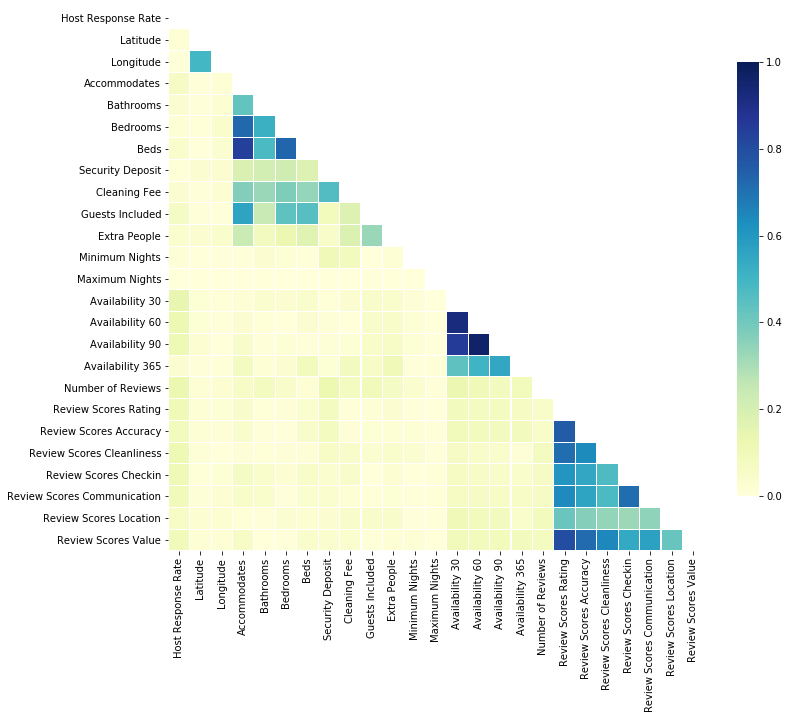

In [11]:
import seaborn as sns

# Compute the correlation matrix
corr = np.abs(df.drop(['Price'], axis=1).corr())
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

# puedo representar solo la parte inferior ya que es simétrica

Vemos que hay mucha correlación entre las variables de availability y las de reviews. Podemos eliminar todas las availability salvo 365 y hacer una media de las de review; he decidido hacer media porque son reviews, pero podría escogerse otra estrategia, o incluso conservarlas todas ya que técnicamente no hacen referencia a la misma info. Eliminamos también Accommodates que tiene correlación alta con Beds.

In [12]:
reviews = df.loc[: , "Review Scores Rating":"Review Scores Value"]
df['Average Review'] = reviews.mean(axis=1)

df.drop(['Availability 30', 'Availability 60', 'Availability 90', 'Review Scores Rating', 
         'Review Scores Accuracy', 'Review Scores Cleanliness', 'Review Scores Checkin',
       'Review Scores Communication', 'Review Scores Location', 'Review Scores Value',
        'Accommodates'], axis=1, inplace=True)

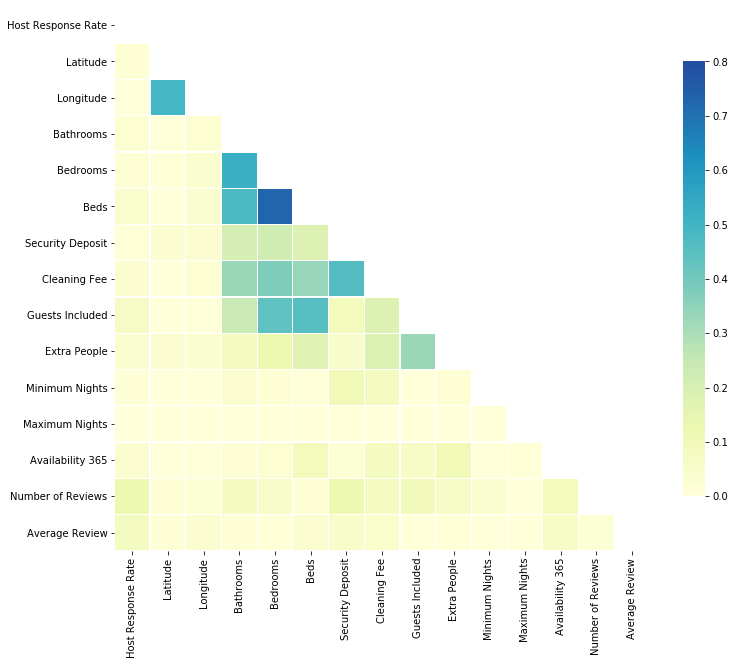

In [13]:
# Compute the correlation matrix
corr = np.abs(df.drop(['Price'], axis=1).corr())
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=0.8, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

# La matriz de correlación tiene mejor pinta

Por último, podemos hacer una representación (scatter_plot) de todas las variables frente al resto, para tener una idea de cómo se relacionan las variables del problema.

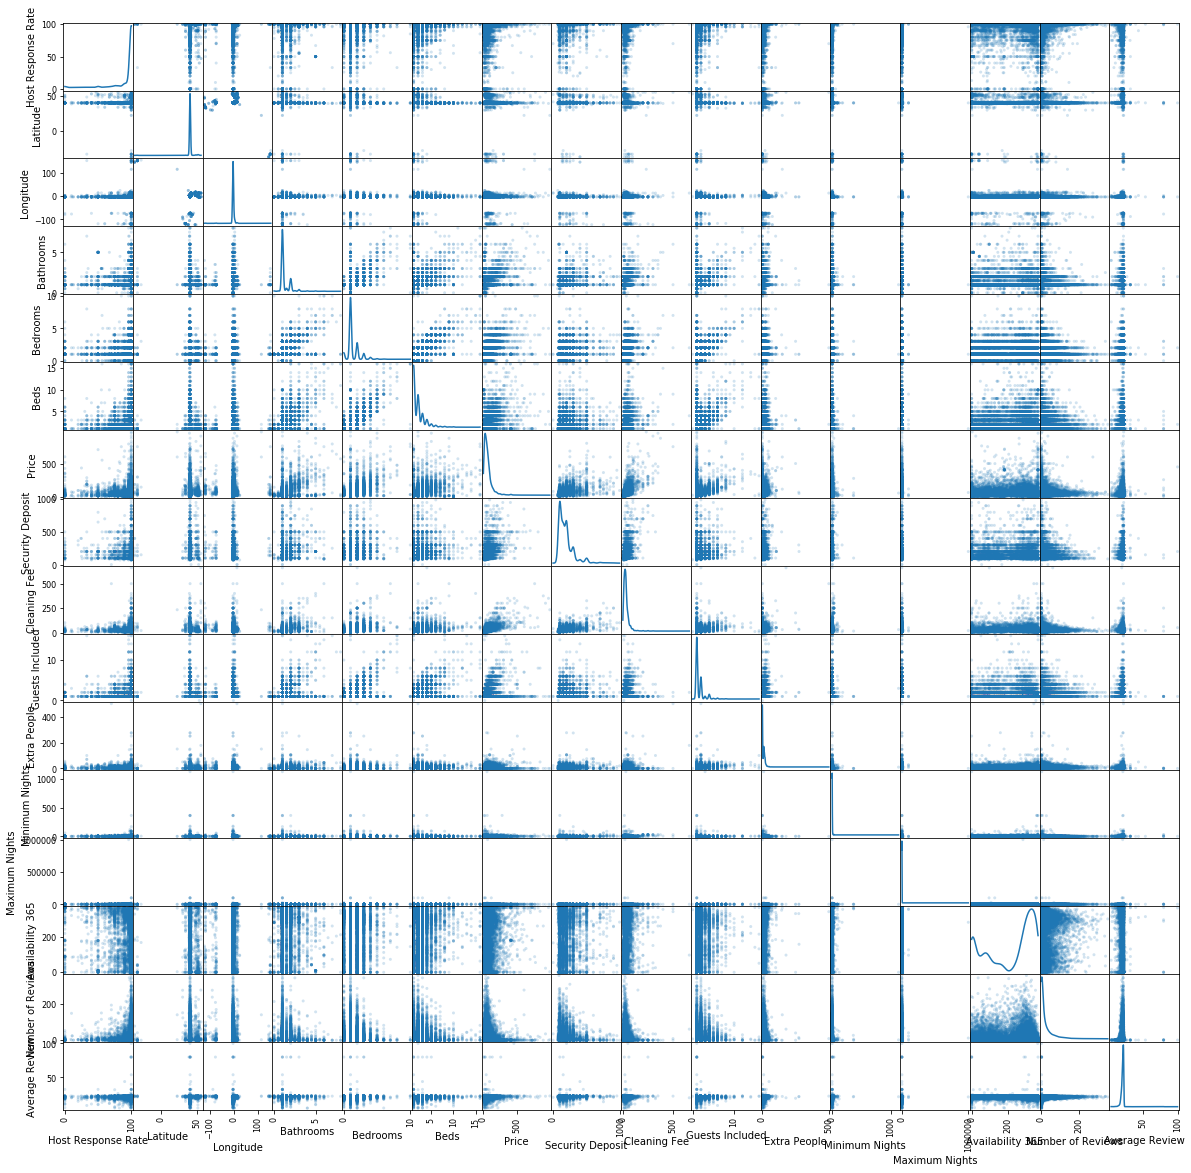

In [14]:
pd.plotting.scatter_matrix(df, alpha=0.2, figsize=(20, 20), diagonal = 'kde')
plt.show()

Por último, vamos a eliminar outliers en la variable Price usando un filtro.

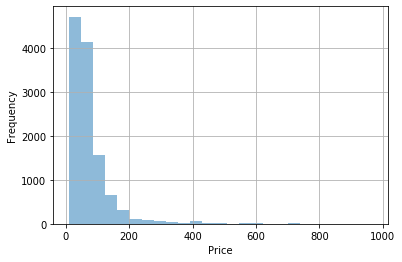

In [15]:
df['Price'].plot.hist(alpha=0.5, bins=25, grid = True)
plt.xlabel('Price')

plt.show()

In [16]:
len(df[df['Price'] > 200]) # tan solo estos valores (de 12k!) son mayores de 200. Es un filtro válido.
# Haced la prueba, con > 100 saldrán en torno a 2k valores, que es un corte mucho mayor.

464

In [17]:
# Cuidado, que esto también elimina los nulos! En este caso no importa, pero hay que revisar si el filtro
# se carga muchos valores

df = df[df['Price'] < 200]

Tras el primer análisis se ha bajado de las 89 columnas iniciales a:

In [18]:
df.shape

(11285, 31)

In [19]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Host Response Rate,9872.0,94.819996,15.120289,0.000000,100.000000,100.000000,100.000000,100.000000
Latitude,11285.0,40.486071,4.595661,-37.851182,40.409773,40.419178,40.430520,55.966912
Longitude,11285.0,-3.821344,13.528603,-123.124429,-3.707585,-3.700942,-3.685942,153.371427
Bathrooms,11245.0,1.232815,0.563749,0.000000,1.000000,1.000000,1.000000,8.000000
Bedrooms,11265.0,1.269596,0.777219,0.000000,1.000000,1.000000,1.000000,10.000000
Beds,11251.0,1.931384,1.400477,1.000000,1.000000,1.000000,2.000000,16.000000
Price,11285.0,62.101462,37.735374,9.000000,32.000000,55.000000,80.000000,199.000000
Security Deposit,4831.0,181.717450,105.519681,0.000000,100.000000,150.000000,200.000000,990.000000
Cleaning Fee,6689.0,28.722679,20.315457,0.000000,15.000000,25.000000,35.000000,250.000000
Guests Included,11285.0,1.536110,0.997006,0.000000,1.000000,1.000000,2.000000,16.000000


# 2. Generación de características

Parece curioso que haya tres variables diferentes con información sobre el vecindario; a ver qué pasa si se muestran más filas:

In [20]:
df_n = df[['Neighbourhood', 'Neighbourhood Cleansed', 'Neighbourhood Group Cleansed']]
df_n.head(20)

,Neighbourhood,Neighbourhood Cleansed,Neighbourhood Group Cleansed
0,Jerónimos,Jerónimos,Retiro
1,NaN,Sol,Centro
2,Carabanchel,Vista Alegre,Carabanchel
3,NaN,Embajadores,Centro
4,Gaztambide,Gaztambide,Chamberí
5,Embajadores,Embajadores,Centro
6,NaN,Palacio,Centro
7,Sol,Sol,Centro
8,NaN,Calvià,NaN
9,Goya,Goya,Salamanca


Parece que va de más detalle a menos. Si observamos los valores únicos de cada columna se ve que cleansed no tiene valores missing:

In [21]:
print(f'El dataframe tiene un total de {len(df_n)} filas.')
len(df_n) - df_n.count() # vemos cuántos valores NaN hay por columna

El dataframe tiene un total de 11285 filas.


Neighbourhood                   3917
Neighbourhood Cleansed             0
Neighbourhood Group Cleansed     667
dtype: int64

Pero a cambio tiene muchos más valores diferentes:

In [22]:
df_n.apply(lambda x: len(x.unique())) # vemos el número de valores distintos por columna

Neighbourhood                   323
Neighbourhood Cleansed          418
Neighbourhood Group Cleansed     47
dtype: int64

#### Primera creación de características

Se va a usar Neighbourhood Group Cleansed a no ser que sea NaN/Null; en ese caso se rellenará con Neighbourhood Cleansed

In [23]:
df_n["Final Neighbourhood"] = df_n["Neighbourhood Group Cleansed"].fillna(df_n["Neighbourhood Cleansed"])

In [24]:
len(df_n) - df_n.count() # Final neighbourhood no tiene valores missing

Neighbourhood                   3917
Neighbourhood Cleansed             0
Neighbourhood Group Cleansed     667
Final Neighbourhood                0
dtype: int64

In [25]:
df_n.apply(lambda x: len(x.unique())) # y aunque tiene más valores diferentes que group cleansed, tiene menos que cleansed

Neighbourhood                   323
Neighbourhood Cleansed          418
Neighbourhood Group Cleansed     47
Final Neighbourhood             253
dtype: int64

Aplicamos al dataset original y eliminamos las tres columnas de neighbourhood:

In [26]:
df["Final Neighbourhood"] = df["Neighbourhood Group Cleansed"].fillna(df["Neighbourhood Cleansed"])
df.drop(["Neighbourhood", "Neighbourhood Group Cleansed", "Neighbourhood Cleansed"], axis=1, inplace=True)

#### Segunda generación de características:

Host Verifications, Features y Amenities exigirían un análisis NLP, pero hay información directa que se puede extraer. Todas son listas, separadas por comas. Se puede contar el número de elementos en cada lista y usarlo como característica.

**Nota**: Estas generaciones de características se me han ocurrido sobre la marcha y me parece que pueden tener sentido; alguien podría argumentarme en contra que si una casa tiene secador de pelo y bolsitas de té para el desayuno tendría 2 Amenities, mientras que otra con WiFi (pero sin secador ni té) tendría 1, y que por tanto es una generación incorrecta porque debería darle más peso a determinadas Amenities frente a otras. Toda la razón, no todas las Features/Amenities deberían contar igual, y se podría realizar un análisis de frecuencias para asignarles un peso, o decidir manualmente cuáles son las más importantes; recordad que esto es solo una introducción al ML! Todo lo que queráis avanzar y probar está genial, adelante.

In [27]:
df_l = df[['Features', 'Amenities', 'Host Verifications']]
df_l.fillna("", inplace=True) # rellenamos los huecos con cadenas vacías

df_l['Features'] = df_l['Features'].apply(lambda x: len(str(x).split(',')))
df_l['Amenities'] = df_l['Amenities'].apply(lambda x: len(str(x).split(',')))
df_l['Host Verifications'] = df_l['Host Verifications'].apply(lambda x: len(str(x).split(',')))

df_l.head(10)

,Features,Amenities,Host Verifications
0,3,13,4
1,4,18,6
2,5,25,7
3,2,5,4
4,4,15,4
5,5,15,4
6,3,20,3
7,3,12,4
8,4,20,5
9,6,23,5


Aplicamos al dataset original:

In [28]:
df['Features'].fillna("", inplace=True)
df['Amenities'].fillna("", inplace=True)
df['Host Verifications'].fillna("", inplace=True)

df['Features'] = df['Features'].apply(lambda x: len(str(x).split(',')))
df['Amenities'] = df['Amenities'].apply(lambda x: len(str(x).split(',')))
df['Host Verifications'] = df['Host Verifications'].apply(lambda x: len(str(x).split(',')))

In [29]:
df.columns

Index(['Experiences Offered', 'Host Since', 'Host Response Time',
       'Host Response Rate', 'Host Verifications', 'City', 'Country Code',
       'Latitude', 'Longitude', 'Property Type', 'Room Type', 'Bathrooms',
       'Bedrooms', 'Beds', 'Bed Type', 'Amenities', 'Price',
       'Security Deposit', 'Cleaning Fee', 'Guests Included', 'Extra People',
       'Minimum Nights', 'Maximum Nights', 'Availability 365',
       'Number of Reviews', 'Cancellation Policy', 'Features',
       'Average Review', 'Final Neighbourhood'],
      dtype='object')

#### Tercera generación de características

Antigüedad del dueño en la plataforma

In [30]:
from datetime import datetime

df.dropna(subset=['Host Since'], inplace=True) # se ha visto antes que solo hay tres valores missing, no se pierde mucho

df['Host Since'] = df['Host Since'].apply(lambda x: datetime.strptime(str(x),'%Y-%m-%d'))
df['Years Being Host'] = df['Host Since'].apply(lambda x: 2017 - x.year)

df.drop(['Host Since'], axis=1, inplace=True)

# 3. Categorización de variables

De qué tipo son las columnas restantes? Las numéricas se convierten a float, y se va a hacer una limpieza general: cero baños, precio cero... esas cosas pueden y deben limpiarse al recoger los datos. 

In [31]:
print(f"Registros con cero baños: {len(df[df['Bathrooms'] == 0])}")
print(f"Registros con precio cero: {len(df[df['Price'] == 0])}")
      
df = df[df['Bathrooms'] != 0]
df = df[df['Price'] != 0]

Registros con cero baños: 53
Registros con precio cero: 0


Se ve que las columnas no numéricas que quedan son:

In [32]:
list(df.select_dtypes(include=['object']).columns)

['Experiences Offered',
 'Host Response Time',
 'City',
 'Country Code',
 'Property Type',
 'Room Type',
 'Bed Type',
 'Cancellation Policy',
 'Final Neighbourhood']

In [33]:
df_nn = df[list(df.select_dtypes(include=['object']).columns)]
df_nn.apply(lambda x: len(x.unique())) # valores diferentes

Experiences Offered      5
Host Response Time       5
City                   192
Country Code            16
Property Type           21
Room Type                3
Bed Type                 5
Cancellation Policy      8
Final Neighbourhood    253
dtype: int64

In [34]:
len(df_nn) - df_nn.count() # solo market y host response time tienen missing values

Experiences Offered       0
Host Response Time     1388
City                      2
Country Code              0
Property Type             0
Room Type                 0
Bed Type                  0
Cancellation Policy       0
Final Neighbourhood       0
dtype: int64

In [35]:
df_nn["Host Response Time"].value_counts()

within an hour        6076
within a few hours    2180
within a day          1361
a few days or more     224
Name: Host Response Time, dtype: int64

Como no tenemos más datos, rellenamos con la opción más frecuente, en este caso within an hour, sobre el dataset original.

In [36]:
df["Host Response Time"].fillna(df["Host Response Time"].mode()[0], inplace=True)

Y la columna experiences offered? Qué valores tiene? Parece que muy pocos, la mayoría son none. Podemos borrarla

In [37]:
df["Experiences Offered"].value_counts()

none        11219
business        4
social          3
family          2
romantic        1
Name: Experiences Offered, dtype: int64

In [38]:
df.drop(['Experiences Offered'], axis=1, inplace=True)

Ahora lo mismo con el resto de columnas

In [39]:
df_nn["City"].value_counts()

Madrid                                 10203
Barcelona                                206
London                                    95
Paris                                     75
Palma                                     40
Berlin                                    32
Roma                                      29
Dublin                                    28
Los Angeles                               24
New York                                  24
Brooklyn                                  21
Alcúdia                                   21
Wien                                      20
Amsterdam                                 18
Rome                                      16
Madrid, Comunidad de Madrid, ES           14
Toronto                                   12
Palma de Mallorca                         10
Inca                                       9
Washington                                 8
Chicago                                    8
Bondi Beach                                7
Santa Marg

In [40]:
df_nn["Country Code"].value_counts()

ES    10668
US      125
GB      118
FR       77
IT       57
AU       34
DE       33
IE       33
AT       26
NL       18
BE       16
CA       15
CH        4
GR        3
CU        1
It        1
Name: Country Code, dtype: int64

En este caso es arriesgado (e incorrecto) rellenar con la moda. Una posibilidad es tratar de inferir el valor correcto de City, muy ruidoso, en función de Market y Street (probadlo si queréis!); otra, simplemente eliminar los 6 registros que no tienen definida la variable. Pero realmente, a estas alturas, lo mejor es simplemente eliminarla, ya que la amplísima mayoría de valores son exactamente iguales: Madrid.

Lo mismo con Country Code.

In [41]:
df.drop(['City', 'Country Code'], axis=1, inplace=True)

Ahora podemos aplicar un encoder sobre las variables categóricas. Aplicamos un smoother extraído [del tutorial de Max Halford](https://maxhalford.github.io/blog/target-encoding-done-the-right-way/), uno de los ejemplos que os puse en Slack. Tened en cuenta que si existieran valores en test no vistos en train, habría que tenerlo en cuenta (quizá creando una categoría "Unknown")

In [42]:
categorical = ['Host Response Time', 'Property Type', 'Room Type', 'Bed Type', 'Cancellation Policy',
 'Final Neighbourhood'
]

# Creamos un dict para usarlo después en test
mean_map = {}
for c in categorical:
    mean = df.groupby(c)['Price'].mean()
    df[c] = df[c].map(mean)    
    mean_map[c] = mean

Por último, rellenamos los valores NaNs con la media de las columnas numéricas

In [43]:
# Esto solo sirve para mover price a la primera posición
cols = df.columns.tolist()
cols.insert(0, cols.pop(cols.index('Price')))
df = df[cols]

df.fillna(df.mean(), inplace=True)
df.isnull().any()

Price                  False
Host Response Time     False
Host Response Rate     False
Host Verifications     False
Latitude               False
Longitude              False
Property Type          False
Room Type              False
Bathrooms              False
Bedrooms               False
Beds                   False
Bed Type               False
Amenities              False
Security Deposit       False
Cleaning Fee           False
Guests Included        False
Extra People           False
Minimum Nights         False
Maximum Nights         False
Availability 365       False
Number of Reviews      False
Cancellation Policy    False
Features               False
Average Review         False
Final Neighbourhood    False
Years Being Host       False
dtype: bool

In [44]:
df.describe()

,Price,Host Response Time,Host Response Rate,Host Verifications,Latitude,Longitude,Property Type,Room Type,Bathrooms,Bedrooms,Beds,Bed Type,Amenities,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Availability 365,Number of Reviews,Cancellation Policy,Features,Average Review,Final Neighbourhood,Years Being Host
count,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000
mean,62.233859,62.233859,94.824611,4.127527,40.492999,-3.835718,62.233859,62.233859,1.238717,1.270140,1.932827,62.233859,14.253807,181.716508,28.742288,1.538516,7.482679,3.000356,965.842551,201.355864,23.292368,62.233859,3.731944,21.260371,62.233859,2.758215
std,37.754485,0.522435,14.139337,1.269430,4.553308,13.483206,5.156736,23.330766,0.557712,0.773861,1.397345,1.554922,4.742390,69.113431,15.670342,0.998690,10.492707,13.239739,9632.615438,128.328316,38.557090,7.206774,1.053737,2.162715,16.645810,1.634771
min,10.000000,59.473214,0.000000,1.000000,-37.851182,-123.124429,20.500000,25.733766,0.500000,0.000000,1.000000,43.222222,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,53.405579,1.000000,4.857143,20.000000,0.000000
25%,32.000000,61.914769,94.824611,3.000000,40.409759,-3.707529,63.083949,34.001611,1.000000,1.000000,1.000000,62.447512,11.000000,181.716508,20.000000,1.000000,0.000000,1.000000,360.000000,77.000000,1.000000,53.405579,3.000000,21.000000,58.250000,1.000000
50%,55.000000,62.525857,100.000000,4.000000,40.419152,-3.700916,63.083949,81.289259,1.000000,1.000000,1.000000,62.447512,14.000000,181.716508,28.742288,1.000000,0.000000,2.000000,1125.000000,239.000000,7.000000,61.350999,4.000000,21.260371,66.813011,3.000000
75%,80.000000,62.525857,100.000000,5.000000,40.430508,-3.685801,63.083949,81.289259,1.000000,1.000000,2.000000,62.447512,17.000000,181.716508,30.000000,2.000000,14.000000,3.000000,1125.000000,319.000000,28.000000,69.885674,4.000000,22.285714,66.813011,4.000000
max,199.000000,62.525857,100.000000,10.000000,55.966912,153.371427,148.333333,81.289259,8.000000,10.000000,16.000000,62.447512,39.000000,990.000000,250.000000,16.000000,276.000000,1125.000000,1000000.000000,365.000000,356.000000,95.882353,8.000000,80.000000,198.000000,8.000000


# 4 Construcción y validación del modelo

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

data = df.values

y_train = data[:,0:1]     # nos quedamos con la 1ª columna, price
X_train = data[:,1:]      # nos quedamos con el resto

feature_names = df.columns[1:]

# Escalamos (con los datos de train)
scaler = preprocessing.StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

alpha_vector = np.logspace(-1.5,-0.5,20)

param_grid = {'alpha': alpha_vector }
grid = GridSearchCV(Lasso(), scoring= 'neg_mean_squared_error', param_grid=param_grid, cv = 10)
grid.fit(XtrainScaled, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = -1*np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('10-Fold MSE')
plt.show()

In [ ]:
df_test = pd.read_csv('./test.csv', sep=';', decimal='.')

not_useful_columns = [
    'ID', 'Listing Url', 'Scrape ID', 'Last Scraped', 'Thumbnail Url', 'Medium Url', 
    'Picture Url', 'XL Picture Url', 'Host ID', 'Host URL', 'Host Name', 
    'Host Thumbnail Url', 'Host Picture Url', 'Host Neighbourhood', 'Weekly Price', 
    'Monthly Price', 'Calendar Updated', 'Calendar last Scraped', 'First Review', 
    'Last Review', 'Reviews per Month', 'Geolocation', 'Calculated host listings count',
    'Host Listings Count', 'Host Total Listings Count'
]
somehow_useful_columns_but_droppable_anyway = ['Name', 'Summary', 'Space', 'Description',
       'Neighborhood Overview', 'Notes', 'Transit', 'Access', 'Interaction', 'House Rules',
       'Host Location', 'Host About'
]
columns_with_too_many_missing_values = [
    'Host Acceptance Rate', 'Square Feet', 'Has Availability', 'License', 'Jurisdiction Names'
]

df_test.drop(not_useful_columns, axis=1, inplace=True)
df_test.drop(somehow_useful_columns_but_droppable_anyway, axis=1, inplace=True)
df_test.drop(['Street', 'State', 'Market', 'Smart Location', 'Country', 'Zipcode'], axis=1, inplace=True)
df_test.drop(columns_with_too_many_missing_values, axis=1, inplace=True)

reviews = df_test.loc[: , "Review Scores Rating":"Review Scores Value"]
df_test['Average Review'] = reviews.mean(axis=1)

df_test.drop(['Availability 30', 'Availability 60', 'Availability 90', 'Review Scores Rating', 
         'Review Scores Accuracy', 'Review Scores Cleanliness', 'Review Scores Checkin',
       'Review Scores Communication', 'Review Scores Location', 'Review Scores Value',
        'Accommodates'], axis=1, inplace=True)

df_test = df_test[df_test['Price'] < 200]

df_test["Final Neighbourhood"] = df_test["Neighbourhood Group Cleansed"].fillna(df_test["Neighbourhood Cleansed"])
df_test.drop(["Neighbourhood", "Neighbourhood Group Cleansed", "Neighbourhood Cleansed"], axis=1, inplace=True)

df_test['Features'].fillna("", inplace=True) # rellenamos los huecos con cadenas vacías
df_test['Amenities'].fillna("", inplace=True)
df_test['Host Verifications'].fillna("", inplace=True)

df_test['Features'] = df_test['Features'].apply(lambda x: len(str(x).split(',')))
df_test['Amenities'] = df_test['Amenities'].apply(lambda x: len(str(x).split(',')))
df_test['Host Verifications'] = df_test['Host Verifications'].apply(lambda x: len(str(x).split(',')))

df_test.dropna(subset=['Host Since'], inplace=True)
df_test['Host Since'] = df_test['Host Since'].apply(lambda x: datetime.strptime(str(x),'%Y-%m-%d'))
df_test['Years Being Host'] = df_test['Host Since'].apply(lambda x: 2017 - x.year)
df_test.drop(['Host Since'], axis=1, inplace=True)

df_test = df_test[df_test['Bathrooms'] != 0]
df_test = df_test[df_test['Price'] != 0]

df_test["Host Response Time"].fillna(df["Host Response Time"].mode()[0], inplace=True)
df_test.drop(['Experiences Offered'], axis=1, inplace=True)
df_test.drop(['City', 'Country Code'], axis=1, inplace=True)

categorical = ['Host Response Time', 'Property Type', 'Room Type', 'Bed Type', 'Cancellation Policy',
 'Final Neighbourhood'
]

# Categorizamos con los datos de train!
for c in categorical:
    df_test[c] = df_test[c].map(mean_map[c])

# Comprobamos que no quedan valores no numéricos
df[categorical].dtypes

In [ ]:
cols = df_test.columns.tolist()
cols.insert(0, cols.pop(cols.index('Price')))
df_test = df_test[cols]

df_test.fillna(df.mean(), inplace=True)

print(df.shape, df_test.shape)

In [ ]:
data_test = df_test.values

y_test = data_test[:,0:1]     # nos quedamos con la 1ª columna, price
X_test = data_test[:,1:]      # nos quedamos con el resto

feature_names_test = df_test.columns[1:]

# recordad que esta normalización/escalado la realizo con el scaler anterior, basado en los datos de training!
XtestScaled = scaler.transform(X_test) 

In [ ]:
from sklearn.metrics import mean_squared_error 

alpha_optimo = grid.best_params_['alpha']#*10 #*100
lasso = Lasso(alpha = alpha_optimo).fit(XtrainScaled,y_train)

ytrainLasso = lasso.predict(XtrainScaled)
ytestLasso  = lasso.predict(XtestScaled)
mseTrainModelLasso = mean_squared_error(y_train,ytrainLasso)
mseTestModelLasso = mean_squared_error(y_test,ytestLasso)

print('MSE Modelo Lasso (train): %0.5g' % mseTrainModelLasso)
print('MSE Modelo Lasso (test) : %0.5g' % mseTestModelLasso)

w = lasso.coef_
for f,wi in zip(feature_names,w):
    print(f,wi)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

Niterations = [500, 1000, 5000, 8000]
learningRate = [0.1, 0.01]

param_grid = {'n_estimators': Niterations,'learning_rate':learningRate }
grid = GridSearchCV(GradientBoostingRegressor(random_state=0, max_depth=3), param_grid=param_grid, cv = 5)
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

In [ ]:
learning_rate = grid.best_params_['learning_rate']
NEstimators = grid.best_params_['n_estimators']

bt = GradientBoostingRegressor(random_state=0, max_depth=3,learning_rate=learning_rate, n_estimators=NEstimators)
bt.fit(X_train,y_train)

error = 1-grid.cv_results_['mean_test_score'].reshape(len(learningRate),len(Niterations))
colors = ['r','b','g','k','m']
for i,lr in enumerate(learningRate):    
    plt.plot(Niterations,error[i,:],colors[i] + '--o',label='lr = %g'%lr)

plt.legend()
plt.xlabel('# iteraciones')
plt.ylabel('5-fold CV Error')
plt.title('train: %0.3f\ntest:  %0.3f'%(bt.score(X_train,y_train),bt.score(X_test,y_test)))
plt.grid()
plt.show()

In [ ]:
importances = bt.feature_importances_
importances = importances / np.max(importances)

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(14,14))
plt.barh(range(X_train.shape[1]),importances[indices])
plt.yticks(range(X_train.shape[1]),feature_names[indices])
plt.show()

In [ ]:
# Otro método que da mejores resultados: Random Forest

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

rf = RandomForestRegressor(oob_score = True)
rf.fit(X_train, y_train)

y_predict = rf.predict(X_test)
rf_testing_set_score = rf.score(X_test, y_test)
rf_median_abs_error = median_absolute_error(y_test, y_predict)
rf_mean_abs_error = mean_absolute_error(y_test, y_predict)
print('R^2 en datos de test: ' + str(round(rf_testing_set_score,3)))
print('Mediana del error en datos de test: ' + str(round(rf_median_abs_error,3)))
print('Media del error en datos de test: ' + str(round(rf_mean_abs_error,3)))

In [ ]:
tuned_parameters = {
    "n_estimators": [100, 500, 1000, 2000]
}

rf_tuned = GridSearchCV(RandomForestRegressor(), cv = 3, param_grid = tuned_parameters)

preds = rf_tuned.fit(X_train, y_train)
best = rf_tuned.best_estimator_ 
y_predict = rf_tuned.predict(X_test)
rft_testing_set_score = rf_tuned.score(X_test, y_test)
rft_median_abs_error = median_absolute_error(y_test, y_predict)
rf_mean_abs_error = mean_absolute_error(y_test, y_predict)

print('Mejores parámetros:', rf_tuned.best_params_)
print('R^2 en datos de test: ' + str(round(rf_testing_set_score,3)))
print('Mediana del error en datos de test: ' + str(round(rf_median_abs_error,3)))
print('Media del error en datos de test: ' + str(round(rf_mean_abs_error,3)))

In [ ]:
df_test.describe()